 Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed    Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   25000   False    0.01      0.00          3118.21 draws/s   0:00:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   25000   False    0.01      0.00          3102.80 draws/s   0:00:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   25000   False    0.01      0.14          3078.55 draws/s   0:00:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   25000   False    0.01      0.00          3076.36 draws/s   0:00:08   0:00:00

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


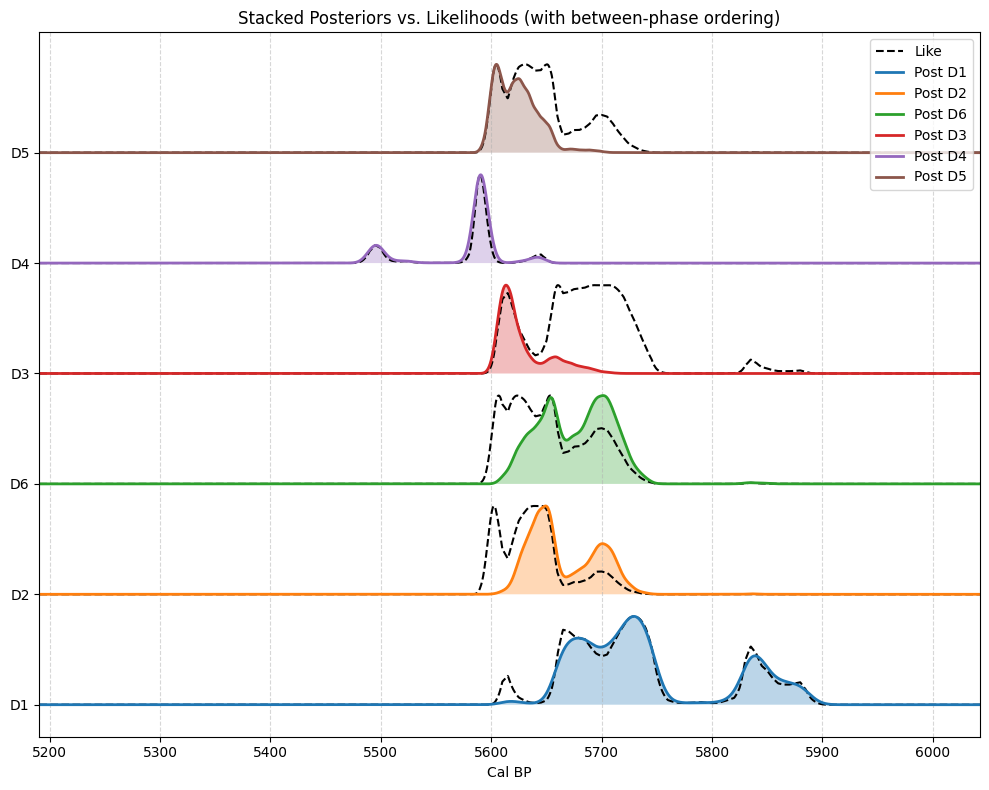

In [7]:
# %% [markdown]
# # Stratigraphic 14C Proof-of-Concept
#
# This notebook-style script shows:
# 1. **DSL** at the top: define your sequence/phase/date model in one place.  
# 2. **Core engine** cells: load calibration data, build and sample the PyMC model.  
# 3. **Visualization**: stacked posteriors vs. raw likelihoods.

# %% [markdown]
# ## 1. Mini-DSL: Define your stratigraphic model here
# (Very close to OxCal syntax, but in pure Python objects.)

# %%
class R_Date:
    """Single 14C measurement."""
    def __init__(self, name, mean, sigma):
        self.name    = name
        self.mean    = mean
        self.sigma   = sigma
        self.var     = None  # to be set to the PyMC variable

class Phase:
    """Unordered group of R_Date objects."""
    def __init__(self, name, *dates):
        self.name    = name
        self.dates   = list(dates)

class Sequence:
    """Ordered list: first any top-level R_Dates, then Phases in sequence."""
    def __init__(self, name, *children):
        self.name     = name
        self.children = children
        # split out any standalone R_Dates before the first Phase:
        self.top_dates = [c for c in children if isinstance(c, R_Date)]
        self.phases    = [c for c in children if isinstance(c, Phase)]

# your model:
MODEL = Sequence("TestSeq",
    Phase("Layer1",
        R_Date("D1", 5000, 25),
        R_Date("D2", 4920, 25),
        R_Date("D6", 4940, 25),
    ),
    Phase("Layer2",
        R_Date("D3", 4970, 25),
        R_Date("D4", 4855, 25),
        R_Date("D5", 4930, 25),
         ),
)

# %% [markdown]
# ## 2. Load IntCal20 and set up interpolation

# %%
import numpy as np, pandas as pd
import pymc as pm, pytensor.tensor as at

# load curve
cal = pd.read_csv("intcal20.14c", comment="#", header=None,
                  names=["CalBP","C14Age","C14Age.sigma","Δ14C","ΔΣ"])
cal = cal.sort_values("CalBP").reset_index(drop=True)
cal_bp  = cal["CalBP"].values
age     = cal["C14Age"].values
age_sig = cal["C14Age.sigma"].values

# tensor versions
cal_bp_tt    = at.as_tensor_variable(cal_bp)
age_tt       = at.as_tensor_variable(age)
age_sig_tt   = at.as_tensor_variable(age_sig)

def interp(x, xp, fp):
    idx = at.clip(at.searchsorted(xp, x, side="right") - 1,
                  0, xp.shape[0]-2)
    x0, x1 = xp[idx], xp[idx+1]
    y0, y1 = fp[idx], fp[idx+1]
    return y0 + (y1-y0)*(x-x0)/(x1-x0)

# %% [markdown]
# ## 3. Build & sample the PyMC model

# %%
def collect_dates(seq):
    """Flatten Sequence → [R_Date,...] in order."""
    out = []
    out.extend(seq.top_dates)
    for ph in seq.phases:
        out.extend(ph.dates)
    return out

def apply_ordering(seq, penalty=-1e6):
    """
    For Sequence seq, build groups = [top_dates] + [each phase.r_dates].
    Then for each adjacent pair (A,B) we add
      0 penalty if every a in A is > every b in B,
      -inf otherwise.
    """
    groups = [seq.top_dates] + [ph.dates for ph in seq.phases]
    for k, (A, B) in enumerate(zip(groups, groups[1:])):
        if not A or not B:
            continue
        for i, da in enumerate(A):
            for j, db in enumerate(B):
                pot_name = f"{seq.name}_grp{k}_i{i}_j{j}"
                pm.Potential(
                    pot_name,
                    at.switch(da.var > db.var, 0.0, -np.inf)
                )

# build & sample
import arviz as az
from scipy.stats import gaussian_kde

with pm.Model() as model:
    dates = collect_dates(MODEL)
    # 1) define variables + likelihoods
    for i, d in enumerate(dates):
        d.var = pm.Uniform(f"age_{i}",
                          lower=cal_bp.min(),
                          upper=cal_bp.max())
        mu    = interp(d.var, cal_bp_tt, age_tt)
        scurv = interp(d.var, cal_bp_tt, age_sig_tt)
        totσ  = at.sqrt(d.sigma**2 + scurv**2)
        pm.Normal(f"obs_{i}", mu=mu, sigma=totσ, observed=d.mean)

    # 2) stratigraphic ordering
    apply_ordering(MODEL)

    # 3) smart init: sort mean ages descending
    means      = np.array([d.mean for d in dates])
    init_order = np.sort(means)[::-1]
    init_vals  = {f"age_{i}": init_order[i] - i*1e-3
                  for i in range(len(dates))}

    trace = pm.sample(20_000, tune=5_000,
                      step=pm.Metropolis(),
                      chains=4, cores=4,
                      initvals=init_vals,
                      return_inferencedata=True)

# %% [markdown]
# ## 4. Plot stacked likelihoods vs. posteriors

# %%
import matplotlib.pyplot as plt

names    = [d.name for d in dates]
posts    = [trace.posterior[f"age_{i}"].values.flatten()
            for i in range(len(dates))]

# combined HDI
allv      = np.concatenate(posts)
lo, hi    = az.hdi(allv, prob=0.95)
xs        = np.linspace(lo-300, hi+300, 2000)

# raw likelihoods
lks = []
for d in dates:
    mu_p  = np.interp(xs, cal_bp, age)
    totσ  = np.sqrt(d.sigma**2 +
                    np.interp(xs, cal_bp, age_sig)**2)
    lk    = np.exp(-0.5*((mu_p-d.mean)/totσ)**2)
    lk   /= np.trapz(lk, xs)
    lks.append(lk)

plt.figure(figsize=(10,8))
for i,(n,post,lk) in enumerate(zip(names,posts,lks)):
    base = i
    # likelihood
    plt.plot(xs, base + lk/lk.max()*0.8, 'k--',
             label="Like" if i==0 else None)
    # posterior
    try:
        dens = gaussian_kde(post)(xs)
        dens = dens/dens.max()*0.8
        plt.fill_between(xs, base, base+dens, alpha=0.3)
        plt.plot(xs, base+dens, lw=2, label=f"Post {n}")
    except:
        xm = np.median(post)
        plt.vlines(xm, base, base+0.8, lw=3, label=f"Post {n}")

plt.yticks(range(len(names)), names)
plt.xlim(xs[0], xs[-1])
plt.xlabel("Cal BP")
plt.title("Stacked Posteriors vs. Likelihoods (with between-phase ordering)")
plt.legend(loc="upper right")
plt.grid(axis='x', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()